In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the data
file_path = '../Data/all_anime_info.csv'
clean_anime_df = pd.read_csv(file_path)

clean_anime_df.head()


,anime_id,genres,type,episodes,source,rating,start_year,start_season,demographics,score,scored_by,members,favorites
0,5114,Action,tv,64,Non-Original,r,2009,spring,Shounen,High,1871705,2932347,204645
1,11061,Action,tv,148,Non-Original,pg_13,2011,fall,Shounen,High,1509622,2418883,185178
2,38524,Action,tv,10,Non-Original,r,2019,spring,Shounen,High,1329500,1881734,51931
3,9253,Drama,tv,24,Non-Original,pg_13,2011,spring,None,High,1252286,2269121,173088
4,28851,Drama,movie,1,Non-Original,pg_13,2016,summer,Shounen,High,1398608,2001335,77431


In [3]:
clean_anime_df.shape

(9451, 13)

In [4]:
# Create our features (in testing)

feature_df = clean_anime_df.drop(columns = ["anime_id", "score", "genres", "start_year", "start_season"])

# features are scored_by, episodes, source, members, favorites, type, rating, & demographics.

X = feature_df

feature_df.head()

,type,episodes,source,rating,demographics,scored_by,members,favorites
0,tv,64,Non-Original,r,Shounen,1871705,2932347,204645
1,tv,148,Non-Original,pg_13,Shounen,1509622,2418883,185178
2,tv,10,Non-Original,r,Shounen,1329500,1881734,51931
3,tv,24,Non-Original,pg_13,None,1252286,2269121,173088
4,movie,1,Non-Original,pg_13,Shounen,1398608,2001335,77431


In [5]:
# Create our target
y = clean_anime_df["score"]
y.value_counts()

Average    5738
High       3713
Name: score, dtype: int64

In [6]:
#Get Dummies
X_encoded = pd.get_dummies(X)
X_encoded.shape

(9451, 24)

In [7]:
data_scaler = StandardScaler()

In [8]:
X_encoded_scaled = data_scaler.fit_transform(X_encoded)
# X_encoded_scaled[:1]

In [9]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state = 1, stratify=y)

# addidng in stratify to help with the imbalance

In [10]:
# Hyperparamenters
n_estimators = [int(x) for x in np.linspace(start = 15, stop = 1500, num = 20)]

max_features = ["auto", "sqrt"]

max_depth = [20, 35, 50, 100, 120]

min_samples_split = [2, 5, 12]

min_samples_leaf = [2, 5, 12]

bootstrap = [True, False]

In [11]:
# Set Parameters
param_grid = {
    "n_estimators" : n_estimators,
    "max_features" : max_features,
    "max_depth" : max_depth,
    "min_samples_split" : min_samples_split,
    "min_samples_leaf" : min_samples_leaf,
    "bootstrap" : bootstrap}

print(param_grid)

{'n_estimators': [15, 93, 171, 249, 327, 405, 483, 562, 640, 718, 796, 874, 952, 1031, 1109, 1187, 1265, 1343, 1421, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 35, 50, 100, 120], 'min_samples_split': [2, 5, 12], 'min_samples_leaf': [2, 5, 12], 'bootstrap': [True, False]}


In [12]:
# Create an instance of the model 

# model
brfc_model = BalancedRandomForestClassifier()

In [13]:
# Begin Cross Validation
Random_Search = RandomizedSearchCV(estimator = brfc_model, param_distributions = param_grid, cv = 25, verbose = 2, n_jobs = 4)

In [14]:
# fit cross validation to training data
Random_Search.fit(X_train, y_train)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


RandomizedSearchCV(cv=25, estimator=BalancedRandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 35, 50, 100, 120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 12],
                                        'min_samples_split': [2, 5, 12],
                                        'n_estimators': [15, 93, 171, 249, 327,
                                                         405, 483, 562, 640,
                                                         718, 796, 874, 952,
                                                         1031, 1109, 1187, 1265,
                                                         1343, 1421, 1500]},
                   verbose=2)

In [15]:
# Find the best parameters
Random_Search.best_params_

{'n_estimators': 1500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [25]:
# Run the optimized model
optimized_model = BalancedRandomForestClassifier(bootstrap = True,
                                                 max_depth = 50,
                                                 max_features = "sqrt",
                                                 min_samples_leaf = 2,
                                                 min_samples_split = 5,
                                                 n_estimators = 1500)


In [26]:
optimized_model = optimized_model.fit(X_train, y_train)

In [27]:
predictions = optimized_model.predict(X_test)

In [28]:
print(f' Train Accuracy - : {optimized_model.score(X_train, y_train):.3f}')
print(f' Test Accuracy - : {optimized_model.score(X_test, y_test):.3f}')

 Train Accuracy - : 0.906
 Test Accuracy - : 0.826


In [29]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, predictions)

0.8282079778925868

In [30]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

    Average       0.89      0.82      0.84      0.85      0.83      0.68      1435
       High       0.75      0.84      0.82      0.79      0.83      0.69       928

avg / total       0.83      0.83      0.83      0.83      0.83      0.69      2363



In [31]:
# List the features sorted in descending order by feature importance
imp_features = optimized_model.feature_importances_

cols = X_encoded.columns

imp_features_df = pd.DataFrame({"feature": cols, "importance": imp_features}).sort_values("importance", ascending=False)
imp_features_df.head(3)

# add in others

,feature,importance
3,favorites,0.300425
2,members,0.226848
1,scored_by,0.208838


In [32]:
estimator = optimized_model.estimators_[5]

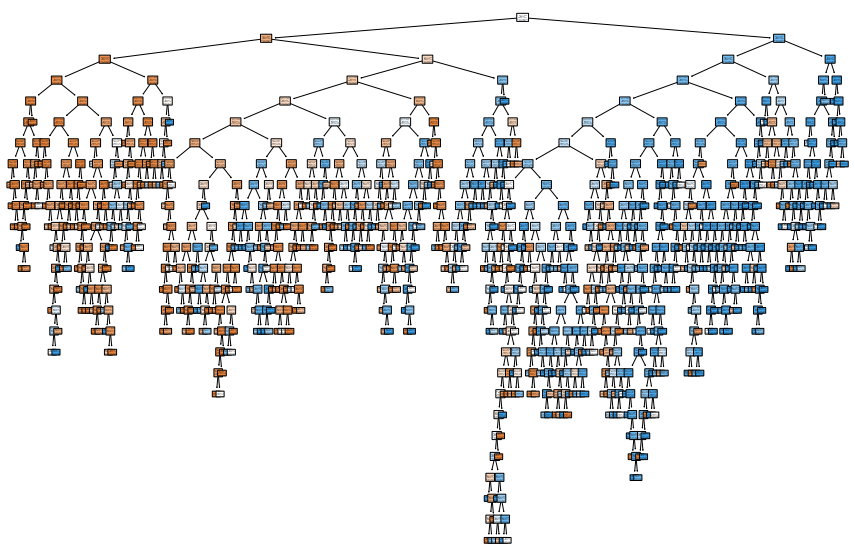

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=249; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=249; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=249; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=249; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=249; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=249; total time=   2.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=12, n_estimators=640; total time=   5.7s
[CV] END bootstrap=True, max_depth=

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(optimized_model.estimators_[0], 
          class_names=clean_anime_df["score"], 
          filled=True, impurity=True, 
          rounded=True)

fig.savefig('decision_tree.png')